### Attempt #1: Change NN Architecture

In [30]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [31]:
#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("Resources/charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [32]:
Counter(application_df['IS_SUCCESSFUL'])

Counter({1: 18261, 0: 16038})

In [33]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns = ['EIN', 'NAME'])

In [34]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [35]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df['APPLICATION_TYPE'].value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T29        2
T15        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

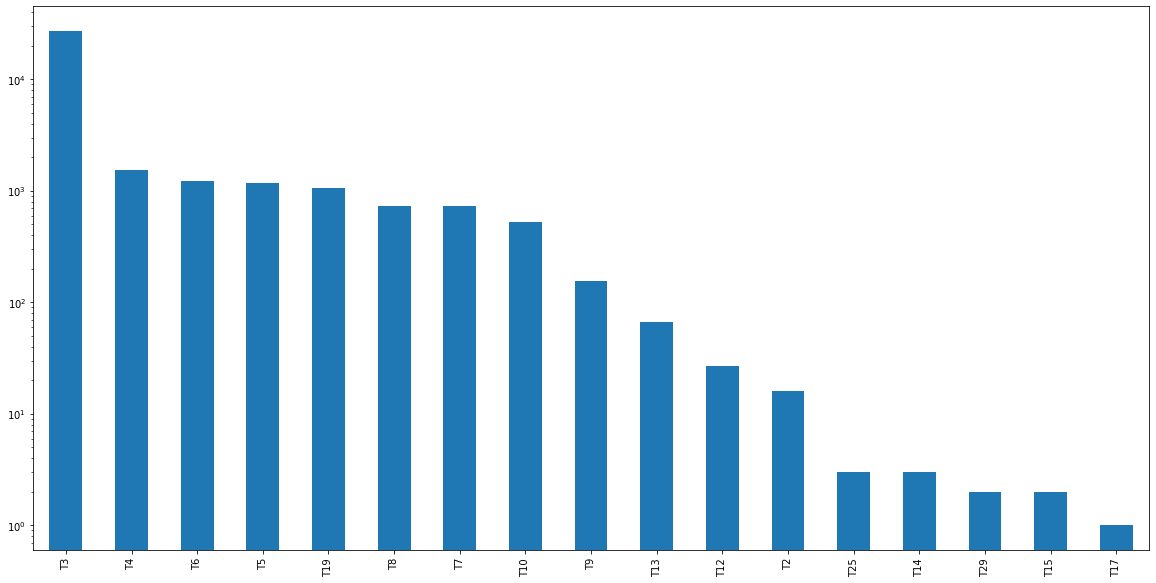

In [36]:
# Visualize the value counts of APPLICATION_TYPE
application_counts.plot.bar()
plt.yscale('log')
plt.show()

In [37]:
# Determine which values to replace if counts are less than 500
replace_application = list(application_counts[application_counts < 500].index)
# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [38]:
# Look at CLASSIFICATION value counts for binning
classification_counts = application_df['CLASSIFICATION'].value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C4120        1
C8210        1
C2561        1
C4500        1
C2150        1
Name: CLASSIFICATION, Length: 71, dtype: int64

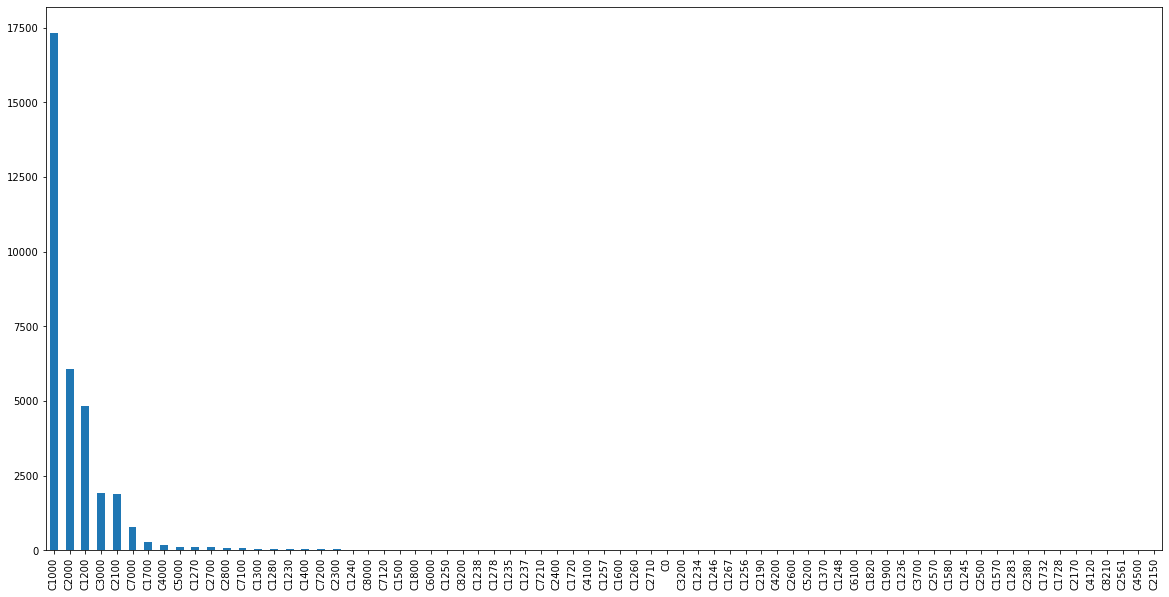

In [39]:
# Visualize the value counts of CLASSIFICATION
classification_counts.plot.bar()
plt.rcParams["figure.figsize"] = (20,10)
# plt.yscale('log')
plt.show()

In [40]:
# Determine which values to replace if counts are less than 1000
replace_class = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [41]:
application_df['INCOME_AMT'].value_counts()

0                24388
25000-99999       3747
100000-499999     3374
1M-5M              955
1-9999             728
10000-24999        543
10M-50M            240
5M-10M             185
50M+               139
Name: INCOME_AMT, dtype: int64

In [42]:
# Generate our categorical variable lists
application_cat = list(application_df.dtypes[application_df.dtypes == object].index)
application_cat

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [43]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [44]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df,
                                     left_index = True,
                                     right_index = True).drop(application_cat, axis = 1)

In [45]:
# Split our preprocessed data into our features and target arrays
y = application_df["IS_SUCCESSFUL"].values
X = application_df.drop(["IS_SUCCESSFUL"], axis = 1).values

# Split the preprocessed data into a training and testbing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [46]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Deliverable 2: Compile, Train and Evaluate the Model

In [47]:
# Define the model - deep neural net
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 120
hidden_nodes_layer2 = 40


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units = hidden_nodes_layer1, 
                          input_dim = number_input_features, 
                          activation = "relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units = hidden_nodes_layer2, 
                             activation = "relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units = 1, 
                             activation = "sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 120)               5280      
_________________________________________________________________
dense_4 (Dense)              (None, 40)                4840      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 41        
Total params: 10,161
Trainable params: 10,161
Non-trainable params: 0
_________________________________________________________________


In [48]:
# Define the checkpoint path and filenames
os.makedirs("Checkpoints/",exist_ok = True)
checkpoint_path = "Checkpoints/weights.{epoch:02d}.hdf5"

In [49]:
# Compile the model

optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
nn.compile(loss = "binary_crossentropy", 
           optimizer = optimizer, 
           metrics = ["accuracy"])

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath = checkpoint_path,
    verbose = 1,
    save_weights_only = True,
    save_freq = 'epoch',
    period = 5
    )

In [50]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs = 32, callbacks = [cp_callback])

Train on 25724 samples
Epoch 1/32
25724/25724 [==============================] - 9s 357us/sample - loss: 0.5864 - accuracy: 0.7137
Epoch 2/32
25724/25724 [==============================] - 4s 143us/sample - loss: 0.5759 - accuracy: 0.7207
Epoch 3/32
25724/25724 [==============================] - 3s 123us/sample - loss: 0.5728 - accuracy: 0.7221
Epoch 4/32
25724/25724 [==============================] - 3s 120us/sample - loss: 0.5708 - accuracy: 0.7251
Epoch 5/32
25376/25724 [============================>.] - ETA: 0s - loss: 0.5714 - accuracy: 0.7241
Epoch 00005: saving model to Checkpoints/weights.05.hdf5
25724/25724 [==============================] - 3s 126us/sample - loss: 0.5715 - accuracy: 0.7239
Epoch 6/32
25724/25724 [==============================] - 4s 158us/sample - loss: 0.5698 - accuracy: 0.7259
Epoch 7/32
25724/25724 [==============================] - 4s 142us/sample - loss: 0.5723 - accuracy: 0.7253
Epoch 8/32
25724/25724 [==============================] - 4s 143us/sample -

In [51]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

8575/1 - 1s - loss: 0.6033 - accuracy: 0.7102
Loss: 0.5807307997667407, Accuracy: 0.7102040648460388


In [52]:
# Export the model to HDF5 file
# nn.save("AlphabetSoupCharity.h5")

### Attempt #2: Logistic Regression and K-fold cross validation

In [53]:
# evaluate a logistic regression model using k-fold cross-validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from numpy import mean
from numpy import std

In [54]:
# create model
log_classifier = LogisticRegression(solver="lbfgs",max_iter=200)

# Train the model
log_classifier.fit(X_train_scaled,y_train)

# Evaluate the model
y_pred = log_classifier.predict(X_test_scaled)
print(f" Logistic regression model accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Logistic regression model accuracy: 0.719


In [55]:
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)

# Scale the full dataset

# Scale the data
X_scaled = X_scaler.transform(X)

# evaluate model
scores = cross_val_score(log_classifier, X_scaled, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.723 (0.006)


### Attempt #3: Random Forest Classifier

In [56]:
# Create a random forest classifier.
rf_model = RandomForestClassifier(n_estimators=128, random_state=78)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(f" Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")

 Random forest predictive accuracy: 0.710


### Attempt #4: Support Vector Machines

In [57]:
from sklearn.svm import SVC

In [58]:
# Create the SVM model
svm = SVC(kernel='linear')

# Train the model
svm.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = svm.predict(X_test_scaled)
print(f" SVM model accuracy: {accuracy_score(y_test,y_pred):.3f}")

 SVM model accuracy: 0.720
